In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")
plt.style.use("bmh")

In [2]:
df = pd.read_csv("data/atlantic.csv")

In [3]:
df["Time"] = df["Time"].astype("object")
time_replace = [str(x) for x in df["Time"].unique()]
for i, txt in enumerate(time_replace):
    time_replace[i] = txt.rjust(4, "0")
    time_replace[i] = f"{time_replace[i][0:2]}:{time_replace[i][2:4]}:00"
for old, new in zip(df["Time"].unique(), time_replace):
    df.loc[df["Time"]==old, "Time"] = new

In [4]:
df["Date"] = df["Date"].astype("object")
for i, date_str in enumerate(df["Date"].unique()):
    df.loc[df["Date"]==date_str, "Date"] = f"{str(date_str)[0:4]}-{str(date_str)[4:6]}-{str(date_str)[6:]}"

In [5]:
df["Datetime"] = df["Date"]+" "+df["Time"]
df["Datetime"] = pd.to_datetime(df["Datetime"])
df.drop(columns=["Date", "Time"], inplace=True)
df.sort_values(by=["Datetime"], inplace=True)

In [6]:
df["Name"] = df["Name"].str.strip()
df["Status"] = df["Status"].str.strip()
df["Event"] = df["Event"].str.strip()

In [7]:
print(f"Dataset contains data of {df['ID'].unique().shape[0]} individual storms from {df['Datetime'].dt.year.min()} to {df['Datetime'].dt.year.max()}.")

Dataset contains data of 1814 individual storms from 1851 to 2015.


In [8]:
def coordinate_mapping(x):
    coord = float(x[:-1])
    if x[-1]=="W":
        coord *= -1
    if x[-1]=="S":
        coord *= -1
    return coord

In [9]:
df["Latitude"] = df["Latitude"].apply(coordinate_mapping)
df["Longitude"] = df["Longitude"].apply(coordinate_mapping)

In [10]:
print("Min. Long.:", df.Longitude.min(), "Max. Long.:", df.Longitude.max(), "Min. Lat.:", df.Latitude.min(), "Max. Lat.:", df.Latitude.max())

Min. Long.: -359.1 Max. Long.: 63.0 Min. Lat.: 7.2 Max. Lat.: 81.0


In [11]:
df.loc[df.Longitude<-180, "Longitude"] = df.Longitude+360

In [12]:
gdf = gpd.GeoDataFrame(df,geometry=gpd.points_from_xy(df.Longitude,df.Latitude), crs={'init' :'epsg:3786'})

In [13]:
gdf.crs

<Derived Projected CRS: EPSG:3786>
Name: World Equidistant Cylindrical (Sphere)
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Coordinate Operation:
- name: World Equidistant Cylindrical (Sphere)
- method: Equidistant Cylindrical (Spherical)
Datum: Not specified (based on GRS 1980 Authalic Sphere)
- Ellipsoid: GRS 1980 Authalic Sphere
- Prime Meridian: Greenwich

In [14]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

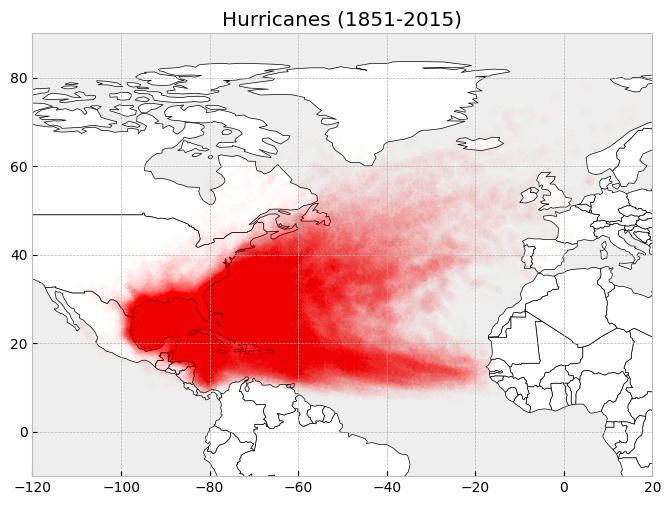

In [15]:
ax = world.plot(color="white", edgecolor="black", figsize=(8,8))
_ = gdf.plot(ax=ax, c="r", markersize="Maximum Wind", alpha=0.01)
_ = plt.xlim(-120, 20)
_ = plt.ylim(-10, 90)
_ = plt.title(f'Hurricanes (1851-2015)')

In [16]:
lat_min = gdf.Latitude.min()
long_min = gdf.Longitude.min()
gdf["x"] = gdf.Latitude-lat_min
gdf["x"] = gdf["x"]/gdf["x"].max()
gdf["y"] = gdf.Longitude-long_min
gdf["y"] = gdf["y"]/gdf["y"].max()

In [17]:
gdf["relative_time"] = ((gdf.Datetime.dt.dayofyear+(gdf.Datetime.dt.hour/24.)+(gdf.Datetime.dt.minute/60.*24))/366.) 
# Each day is 1/366 of a year (WITH 31th of december), each hour is a 1/24 of a day and each minute 1/60 of a hour.

In [18]:
gdf["month"] = gdf.Datetime.dt.month
gdf["hour"] = gdf.Datetime.dt.hour

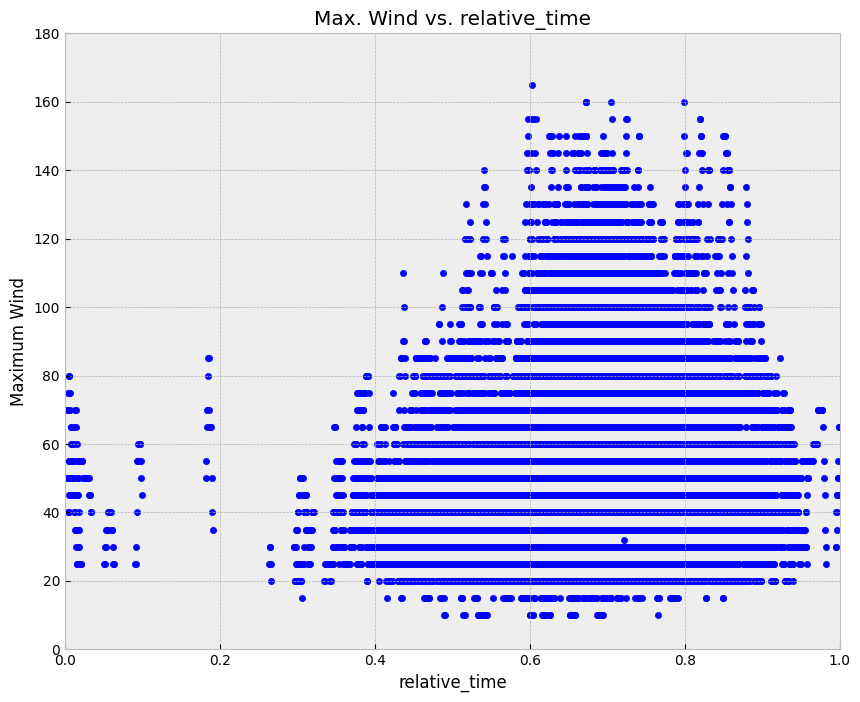

In [19]:
_ = gdf.plot(x="relative_time", y="Maximum Wind", kind="scatter", figsize=(10,8), title="Max. Wind vs. relative_time")
_ = plt.ylim(0,180)
_ = plt.xlim(0,1)

In [20]:
gdf["vec_x"] = np.nan
gdf["vec_y"] = np.nan
vecs = {"x": [], "y": [], "id": []}
for storm_id in gdf["ID"].unique():
    last_x = 0
    last_y = 0
    for i, row in gdf[gdf["ID"]==storm_id].iterrows():
        if last_x==0:
            last_x = row.x
            last_y = row.y
        else:
            vec_x = row.x-last_x
            vec_y = row.y-last_y
            vecs["x"].append(vec_x)
            vecs["y"].append(vec_y)
            vecs["id"].append(i)
            last_x = row.x
            last_y = row.y
gdf.loc[vecs["id"], "vec_x"] = vecs["x"]
gdf.loc[vecs["id"], "vec_y"] = vecs["y"]

In [21]:
gdf["vec_len"] = np.sqrt((gdf["vec_x"]**2)+(gdf["vec_y"]**2))

In [22]:
def calculate_direction(vec_x, vec_y):
    def vec_angle(a, b):
        return np.arccos(np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b)))
    ref_vec = np.array([vec_x, vec_y])
    N_vec = np.array([0,1])
    S_vec = np.array([0,-1])
    E_vec = np.array([1,0])
    W_vec = np.array([-1,0])
    N_angle = vec_angle(ref_vec, N_vec)
    E_angle = vec_angle(ref_vec, E_vec)
    W_angle = vec_angle(ref_vec, W_vec)
    return_angle = N_angle
    if W_angle<E_angle:
        return_angle = 2*np.pi-return_angle
    return return_angle

In [23]:
gdf["vec_direction"] = gdf.apply(lambda x: calculate_direction(x.vec_x, x.vec_y), axis=1)

In [24]:
gdf["tdelta"] = np.nan
tdeltas = {"t": [], "id": []}
for storm_id in gdf["ID"].unique():
    last_time = 0
    for i, row in gdf[gdf["ID"]==storm_id].iterrows():
        if last_time==0:
            last_time = row.Datetime
        else:
            tdeltas["t"].append((row.Datetime-last_time).seconds)
            tdeltas["id"].append(i)
            last_time = row.Datetime
gdf.loc[tdeltas["id"], "tdelta"] = tdeltas["t"]

In [25]:
print(gdf.shape)
gdf = gdf[gdf["tdelta"] % 21600 == 0]
print(gdf.shape)

(49105, 32)
(45717, 32)


In [26]:
def window_input_output(input_length: int, output_length: int, column: str, data: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    df = data.copy()
    i = 1
    while i < input_length:
        df[f'x{column[4:]}_{i}'] = df[column].shift(-i)
        i = i + 1    
    j = 0
    while j < output_length:
        df[f'y{column[4:]}_{j}'] = df[column].shift(-output_length-j)
        j = j + 1   
    df = df.dropna(axis=0)
    return df

In [27]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import RegressorChain
from sklearn.metrics import mean_squared_error

In [43]:
best_models = {'i1':[], 'j1':[], 'i2':[], 'j2':[], 'direction_model':[], 'direction_error':[], 'len_model':[], 'len_error':[]}
min_direction_error = 1000
min_len_error = 1000

all_models = pd.DataFrame({'i':[],'j':[],'model':[],'error':[]})

for i in range(4):
    for j in range(4):
        seq_gdf = window_input_output(i+1, j+1, "vec_len", gdf)
        seq_gdf = window_input_output(i+1, j+1, "vec_direction", seq_gdf)
        
        X_direction_cols = ["Maximum Wind", "x", "y", "month", "hour", "vec_len", "vec_direction"]
        X_direction_cols.extend([col for col in seq_gdf.columns if col.startswith('xd')])
        y_direction_cols = [col for col in seq_gdf.columns if col.startswith('yd')]

        X_direction_train = seq_gdf[X_direction_cols][:-1*round(seq_gdf.shape[1]*0.20)].values
        y_direction_train = seq_gdf[y_direction_cols][:-1*round(seq_gdf.shape[1]*0.20)].values
        X_direction_test = seq_gdf[X_direction_cols][-1*round(seq_gdf.shape[1]*0.20):].values
        y_direction_test = seq_gdf[y_direction_cols][-1*round(seq_gdf.shape[1]*0.20):].values


        X_len_cols = ["Maximum Wind", "x", "y", "month", "hour", "vec_len", "vec_direction"]
        X_len_cols.extend([col for col in seq_gdf.columns if col.startswith('xl')])
        y_len_cols = [col for col in seq_gdf.columns if col.startswith('yl')]

        X_len_train = seq_gdf[X_len_cols][:-1*round(seq_gdf.shape[1]*0.20)].values
        y_len_train = seq_gdf[y_len_cols][:-1*round(seq_gdf.shape[1]*0.20)].values
        X_len_test = seq_gdf[X_len_cols][-1*round(seq_gdf.shape[1]*0.20):].values
        y_len_test = seq_gdf[y_len_cols][-1*round(seq_gdf.shape[1]*0.20):].values

        dt_direction_seq = DecisionTreeRegressor(random_state=42)
        dt_direction_seq.fit(X_direction_train, y_direction_train)
        dt_direction_seq_preds = dt_direction_seq.predict(X_direction_test)
        all_models = all_models.append({'i':i, 'j':j, 'model':'dt_direction_seq', 'error':mean_squared_error(y_direction_test, dt_direction_seq_preds)}, ignore_index=True)
        if mean_squared_error(y_direction_test, dt_direction_seq_preds) < min_direction_error:
            min_direction_error = mean_squared_error(y_direction_test, dt_direction_seq_preds)
            best_models["direction_error"] = mean_squared_error(y_direction_test, dt_direction_seq_preds)
            best_models["direction_model"] = dt_direction_seq
            best_models["i1"] = i + 1
            best_models["j1"] = j + 1

        gbr_direction_seq = GradientBoostingRegressor(random_state=42)
        chained_direction_gbr = RegressorChain(gbr_direction_seq)
        chained_direction_gbr.fit(X_direction_train, y_direction_train)
        gbr_direction_seq_preds = chained_direction_gbr.predict(X_direction_test)
        all_models = all_models.append({'i':i, 'j':j, 'model':'chained_direction_gbr', 'error':mean_squared_error(y_direction_test, gbr_direction_seq_preds)}, ignore_index=True)
        if mean_squared_error(y_direction_test, gbr_direction_seq_preds) < min_direction_error:
            min_direction_error = mean_squared_error(y_direction_test, gbr_direction_seq_preds)
            best_models["direction_error"] = mean_squared_error(y_direction_test, gbr_direction_seq_preds)
            best_models["direction_model"] = chained_direction_gbr
            best_models["i1"] = i + 1
            best_models["j1"] = j + 1

        dt_len_seq = DecisionTreeRegressor(random_state=42)
        dt_len_seq.fit(X_len_train, y_len_train)
        dt_len_seq_preds = dt_len_seq.predict(X_len_test)
        all_models = all_models.append({'i':i, 'j':j, 'model':'dt_len_seq', 'error':mean_squared_error(y_len_test, dt_len_seq_preds)}, ignore_index=True)
        if mean_squared_error(y_len_test, dt_len_seq_preds) < min_len_error:
            min_len_error = mean_squared_error(y_len_test, dt_len_seq_preds)
            best_models["len_error"] = mean_squared_error(y_len_test, dt_len_seq_preds)
            best_models["len_model"] = dt_len_seq
            best_models["i2"] = i + 1
            best_models["j2"] = j + 1

        gbr_len_seq = GradientBoostingRegressor(random_state=42)
        chained_len_gbr = RegressorChain(gbr_len_seq)
        chained_len_gbr.fit(X_len_train, y_len_train)
        gbr_len_seq_preds = chained_len_gbr.predict(X_len_test)
        all_models = all_models.append({'i':i, 'j':j, 'model':'chained_len_gbr', 'error':mean_squared_error(y_len_test, gbr_len_seq_preds)}, ignore_index=True)
        if mean_squared_error(y_len_test, gbr_len_seq_preds) < min_len_error:
            min_len_error = mean_squared_error(y_len_test, gbr_len_seq_preds)
            best_models["len_error"] = mean_squared_error(y_len_test, gbr_len_seq_preds)
            best_models["len_model"] = chained_len_gbr
            best_models["i2"] = i + 1
            best_models["j2"] = j + 1

In [62]:
all_models['i'] += 1
all_models['i'] = all_models['i'].astype(int)
all_models['j'] += 1
all_models['j'] = all_models['j'].astype(int)

len_models = all_models[all_models['model'].str.contains('len')]
direction_models = all_models[all_models['model'].str.contains('direction')]

print(len_models.sort_values(['error']).head(10))
print(direction_models.sort_values(['error']).head(10))

    i  j            model         error
18  4  3       dt_len_seq  1.549201e-13
50  6  3       dt_len_seq  6.876965e-13
34  5  3       dt_len_seq  3.279842e-12
19  4  3  chained_len_gbr  2.135574e-08
35  5  3  chained_len_gbr  3.310921e-08
51  6  3  chained_len_gbr  3.979585e-08
55  6  4  chained_len_gbr  4.019998e-08
54  6  4       dt_len_seq  1.273266e-07
39  5  4  chained_len_gbr  1.746868e-05
3   3  3  chained_len_gbr  1.898897e-05
    i  j                  model         error
16  4  3       dt_direction_seq  7.990577e-08
32  5  3       dt_direction_seq  1.318795e-06
48  6  3       dt_direction_seq  3.068838e-06
49  6  3  chained_direction_gbr  1.892545e-04
53  6  4  chained_direction_gbr  1.932355e-04
33  5  3  chained_direction_gbr  2.114391e-04
17  4  3  chained_direction_gbr  4.270107e-04
52  6  4       dt_direction_seq  5.977801e-04
37  5  4  chained_direction_gbr  5.392164e-02
56  6  5       dt_direction_seq  9.621630e-02


In [29]:
i=4
j=4
seq_gdf = window_input_output(i, j, "vec_len", gdf)
seq_gdf = window_input_output(i, j, "vec_direction", seq_gdf)
        
X_direction_cols = ["Maximum Wind", "x", "y", "month", "hour", "vec_len", "vec_direction"]
X_direction_cols.extend([col for col in seq_gdf.columns if col.startswith('xd')])
y_direction_cols = [col for col in seq_gdf.columns if col.startswith('yd')]

X_direction_train = seq_gdf[X_direction_cols][:-1*round(seq_gdf.shape[1]*0.20)].values
y_direction_train = seq_gdf[y_direction_cols][:-1*round(seq_gdf.shape[1]*0.20)].values
X_direction_test = seq_gdf[X_direction_cols][-1*round(seq_gdf.shape[1]*0.20):].values
y_direction_test = seq_gdf[y_direction_cols][-1*round(seq_gdf.shape[1]*0.20):].values


X_len_cols = ["Maximum Wind", "x", "y", "month", "hour", "vec_len", "vec_direction"]
X_len_cols.extend([col for col in seq_gdf.columns if col.startswith('xl')])
y_len_cols = [col for col in seq_gdf.columns if col.startswith('yl')]

X_len_train = seq_gdf[X_len_cols][:-1*round(seq_gdf.shape[1]*0.20)].values
y_len_train = seq_gdf[y_len_cols][:-1*round(seq_gdf.shape[1]*0.20)].values
X_len_test = seq_gdf[X_len_cols][-1*round(seq_gdf.shape[1]*0.20):].values
y_len_test = seq_gdf[y_len_cols][-1*round(seq_gdf.shape[1]*0.20):].values

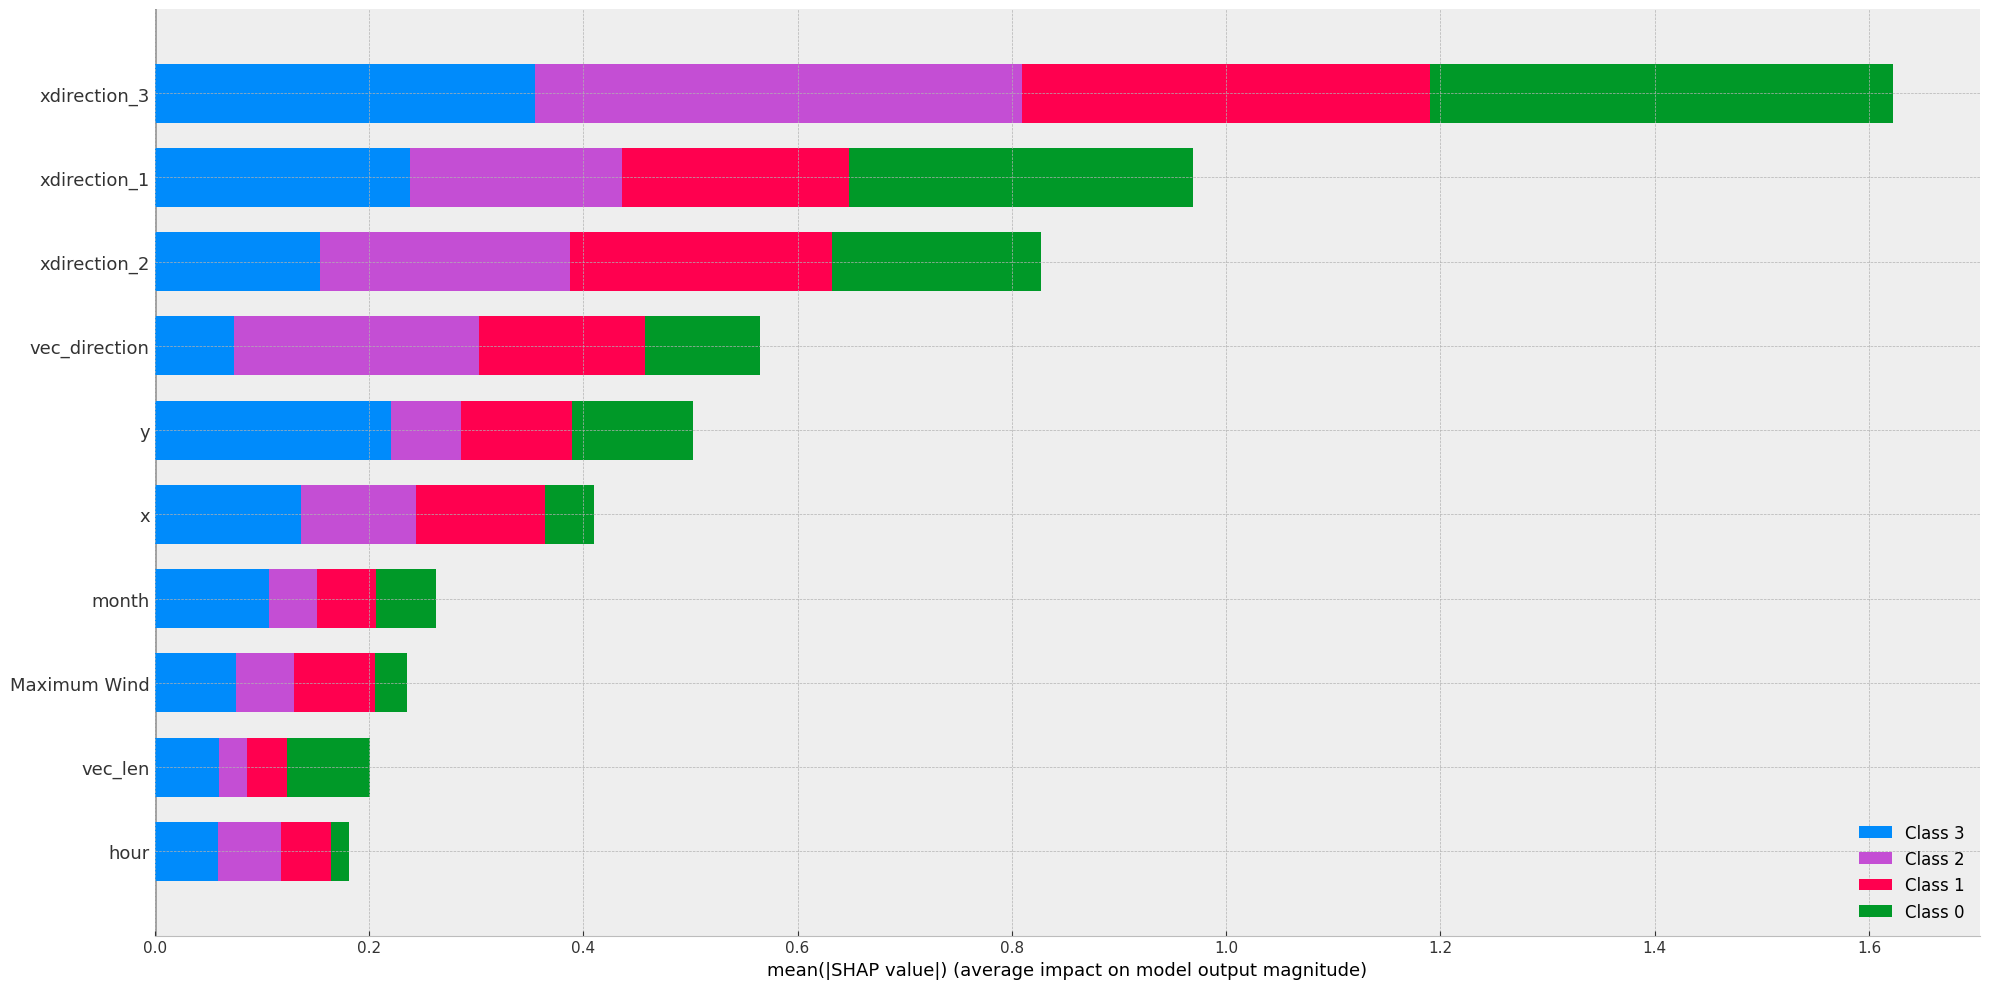

In [30]:
import shap
direction_model = DecisionTreeRegressor(random_state=42).fit(X_direction_train, y_direction_train)
explainer_direction = shap.TreeExplainer(direction_model)
shap_values_direction = explainer_direction.shap_values(X_direction_test, check_additivity=False)
shap.summary_plot(shap_values_direction, X_direction_test, plot_type="bar",
                  feature_names=X_direction_cols, title="Feature importances direction_model",
                  plot_size=(20,10))

In [31]:
if best_models['i1'] == best_models['i2'] and best_models['j1'] == best_models['j2']:
    i = best_models['i1']
    j = best_models['j1']

seq_gdf = window_input_output(i, j, "vec_len", gdf)
seq_gdf = window_input_output(i, j, "vec_direction", seq_gdf)
        
X_direction_cols = ["Maximum Wind", "x", "y", "month", "hour", "vec_len", "vec_direction"]
X_direction_cols.extend([col for col in seq_gdf.columns if col.startswith('xd')])
y_direction_cols = [col for col in seq_gdf.columns if col.startswith('yd')]

X_direction_train = seq_gdf[X_direction_cols][:-1*round(seq_gdf.shape[1]*0.20)].values
y_direction_train = seq_gdf[y_direction_cols][:-1*round(seq_gdf.shape[1]*0.20)].values
X_direction_test = seq_gdf[X_direction_cols][-1*round(seq_gdf.shape[1]*0.20):].values
y_direction_test = seq_gdf[y_direction_cols][-1*round(seq_gdf.shape[1]*0.20):].values


X_len_cols = ["Maximum Wind", "x", "y", "month", "hour", "vec_len", "vec_direction"]
X_len_cols.extend([col for col in seq_gdf.columns if col.startswith('xl')])
y_len_cols = [col for col in seq_gdf.columns if col.startswith('yl')]

X_len_train = seq_gdf[X_len_cols][:-1*round(seq_gdf.shape[1]*0.20)].values
y_len_train = seq_gdf[y_len_cols][:-1*round(seq_gdf.shape[1]*0.20)].values
X_len_test = seq_gdf[X_len_cols][-1*round(seq_gdf.shape[1]*0.20):].values
y_len_test = seq_gdf[y_len_cols][-1*round(seq_gdf.shape[1]*0.20):].values

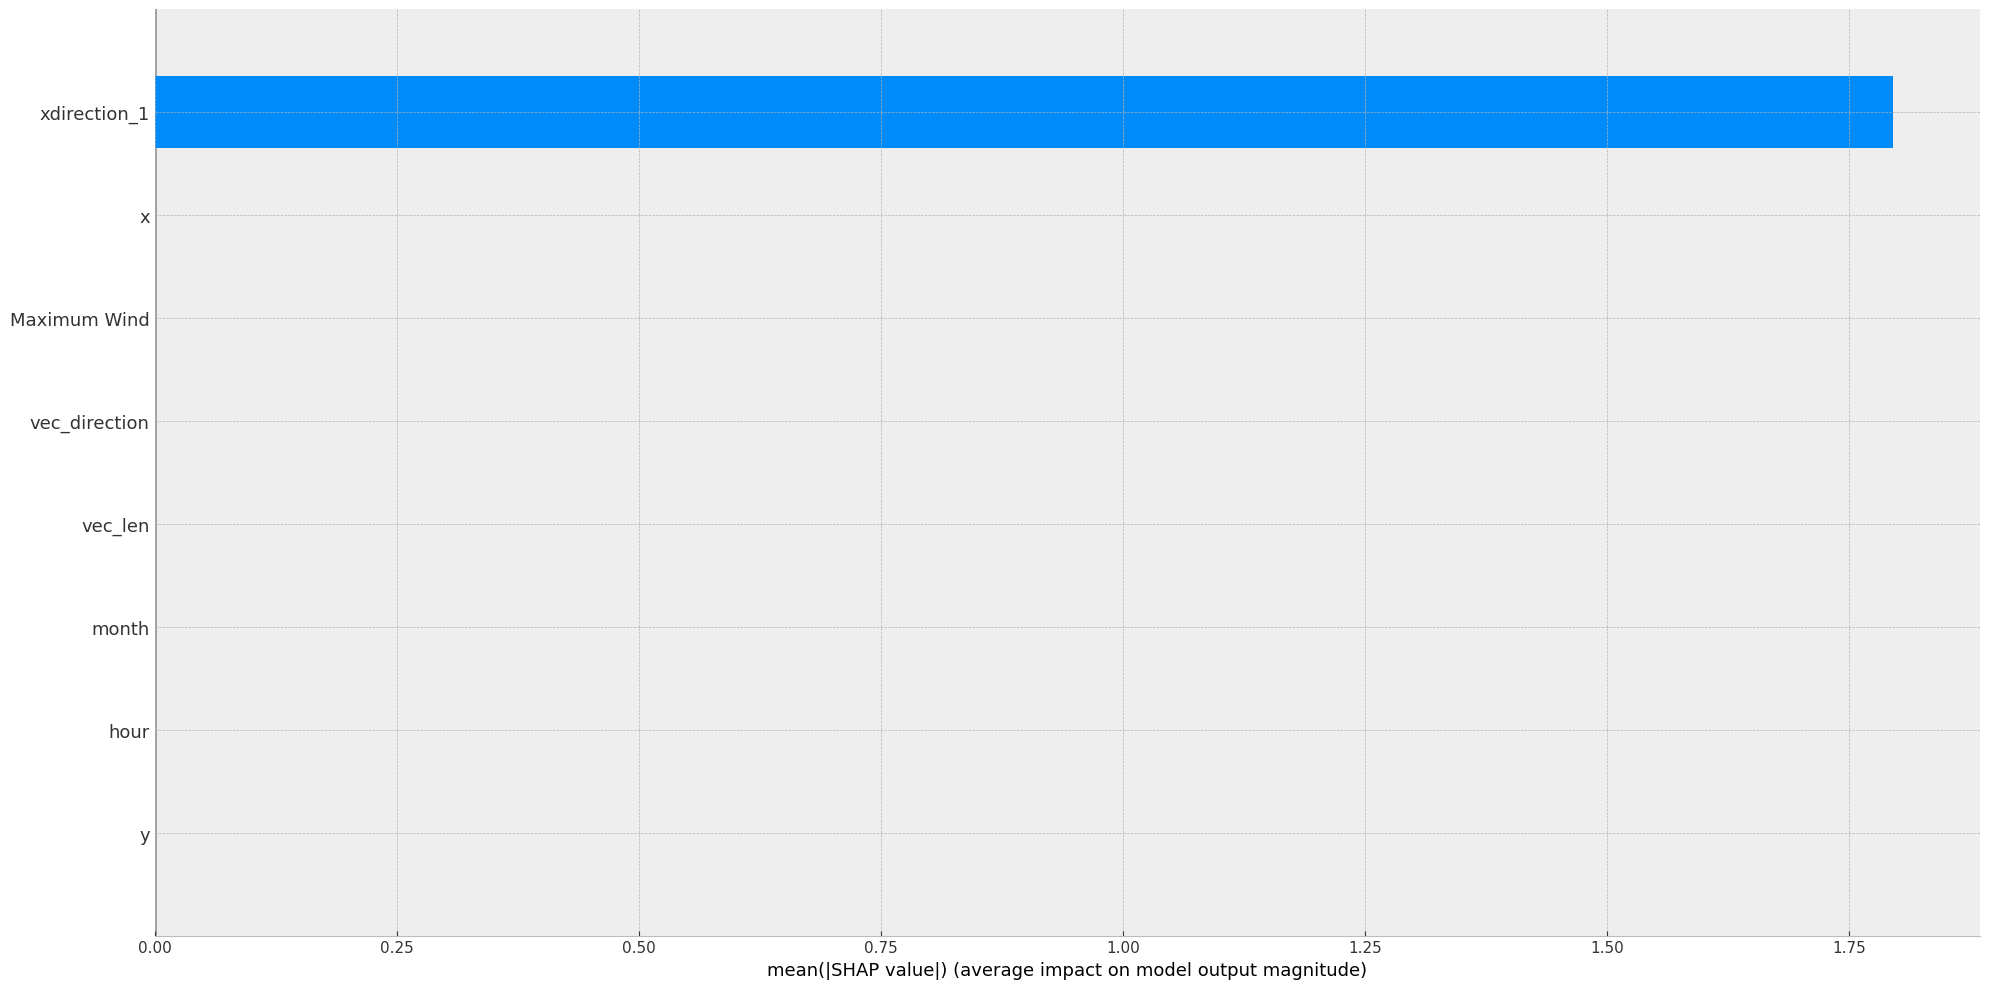

In [32]:
direction_model = DecisionTreeRegressor(random_state=42).fit(X_direction_train, y_direction_train)
explainer_direction = shap.TreeExplainer(direction_model)
shap_values_direction = explainer_direction.shap_values(X_direction_test, check_additivity=False)
shap.summary_plot(shap_values_direction, X_direction_test, plot_type="bar",
                  feature_names=X_direction_cols, title="Feature importances direction_model",
                  plot_size=(20,10))

In [33]:
lat_min = df.Latitude.min()
long_min = df.Longitude.min()
temp_x = df.Latitude-lat_min
temp_y = df.Longitude-long_min
x_max = temp_x.max()
y_max = temp_y.max()

def coords_to_latlong(x, y, lat_min, long_min, x_max, y_max):
    return (x*x_max)+lat_min, (y*y_max)+long_min

In [34]:
seq_gdf[seq_gdf.Name=="DONNA"].ID.unique()

array(['AL051960'], dtype=object)

In [35]:
storm_id = 'AL051960'
gdf_pred = seq_gdf[["Maximum Wind", "x", "y", "month", "hour", "vec_len", "vec_direction", "xlen_1", "xdirection_1"]][seq_gdf.ID==storm_id]
X_pred_direction = gdf_pred[X_direction_cols].iloc[1:].values
X_pred_len = gdf_pred[X_len_cols].iloc[1:].values

In [36]:
len_model = DecisionTreeRegressor(random_state=42).fit(X_len_train, y_len_train)
df_pred = pd.DataFrame({"pred_len": len_model.predict(X_pred_len), "pred_direction": direction_model.predict(X_pred_direction)})

In [37]:
df_pred["pred_x"] = np.nan
df_pred["pred_y"] = np.nan
df_pred["real_x"] = gdf_pred["x"].iloc[1:].values
df_pred["real_y"] = gdf_pred["y"].iloc[1:].values

In [38]:
last_x = gdf_pred["x"].iloc[0]
last_y = gdf_pred["y"].iloc[0]
coords = {"x": [], "y": [], "id": []}
for i, row in df_pred.iterrows():
    vector = np.array([0,1])
    R = np.array([[np.cos(row.pred_direction), -np.sin(row.pred_direction)], [np.sin(row.pred_direction), np.cos(row.pred_direction)]])
    vector = np.matmul(vector, R)
    vector = vector/np.linalg.norm(vector)
    vector *= row.pred_len
    coords["x"].append(last_x+vector[0])
    coords["y"].append(last_y+vector[1])
    coords["id"].append(i)
    last_x = row.real_x
    last_y = row.real_y
df_pred.loc[coords["id"], "pred_x"] = coords["x"]
df_pred.loc[coords["id"], "pred_y"] = coords["y"]

In [39]:
df_pred["pred_Longitude"] = np.nan
df_pred["real_Longitude"] = np.nan
df_pred["pred_Latitude"] = np.nan
df_pred["real_Latitude"] = np.nan
latslongs = {"pred_Longitude": [], "real_Longitude": [], "pred_Latitude": [], "real_Latitude": [], "id": []}
for i, row in df_pred.iterrows():
    real_Latitude, real_Longitude = coords_to_latlong(row.real_x, row.real_y, lat_min, long_min, x_max, y_max)
    latslongs["real_Latitude"].append(real_Latitude)
    latslongs["real_Longitude"].append(real_Longitude)
    pred_Latitude, pred_Longitude = coords_to_latlong(row.pred_x, row.pred_y, lat_min, long_min, x_max, y_max)
    latslongs["pred_Latitude"].append(pred_Latitude)
    latslongs["pred_Longitude"].append(pred_Longitude)
    latslongs["id"].append(i)
df_pred.loc[latslongs["id"], "real_Latitude"] = latslongs["real_Latitude"]
df_pred.loc[latslongs["id"], "real_Longitude"] = latslongs["real_Longitude"]
df_pred.loc[latslongs["id"], "pred_Latitude"] = latslongs["pred_Latitude"]
df_pred.loc[latslongs["id"], "pred_Longitude"] = latslongs["pred_Longitude"]

In [40]:
df_pred

,pred_len,pred_direction,pred_x,pred_y,real_x,real_y,pred_Longitude,real_Longitude,pred_Latitude,real_Latitude
0,0.008228,2.976161,0.040650,0.486377,0.040650,0.486957,-25.6,-25.5,10.2,10.2
1,0.009108,2.839480,0.043360,0.478261,0.042005,0.478841,-27.0,-26.9,10.4,10.3
2,0.009663,2.857330,0.044715,0.469565,0.044715,0.470145,-28.5,-28.4,10.5,10.5
3,0.009663,2.857330,0.047425,0.460870,0.047425,0.460870,-30.0,-30.0,10.7,10.7
4,0.009108,2.839480,0.050136,0.452174,0.050136,0.451594,-31.5,-31.6,10.9,10.9
5,0.009599,2.704298,0.054201,0.442899,0.052846,0.442899,-33.1,-33.1,11.2,11.1
6,0.010127,2.728543,0.056911,0.433623,0.056911,0.434203,-34.7,-34.6,11.4,11.4
7,0.015505,2.078367,0.070461,0.426667,0.060976,0.424928,-35.9,-36.2,12.4,11.7
8,0.010127,2.728543,0.065041,0.415652,0.065041,0.415652,-37.8,-37.8,12.0,12.0
9,0.021483,1.900560,0.085366,0.408696,0.069106,0.406377,-39.0,-39.4,13.5,12.3


In [59]:
gdf_real = gpd.GeoDataFrame(df_pred,geometry=gpd.points_from_xy(df_pred.real_Longitude,df_pred.real_Latitude), crs={'init' :'epsg:3786'})
gdf_pred = gpd.GeoDataFrame(df_pred,geometry=gpd.points_from_xy(df_pred.pred_Longitude,df_pred.pred_Latitude), crs={'init' :'epsg:3786'})

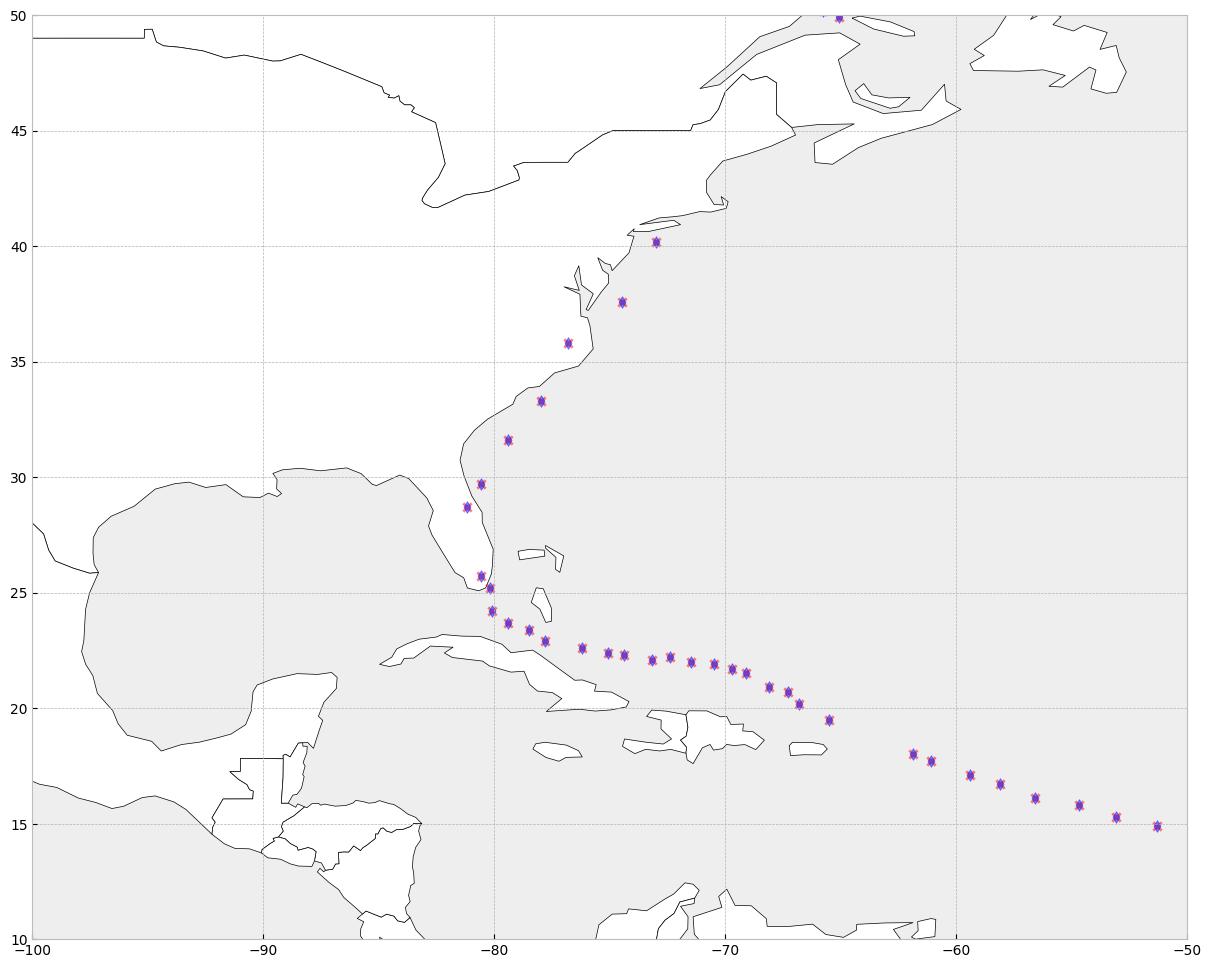

In [60]:
ax = world.plot(color="white", edgecolor="black", figsize=(25,12))
_ = gdf_real.plot(ax=ax, c="r", marker="x", alpha=0.5)
_ = gdf_pred.plot(ax=ax, c="b", marker="d", alpha=0.5)
_ = plt.xlim(-100, -50)
_ = plt.ylim(10, 50)